# import Libraries

In [11]:
import pandas as pd
import numpy as np
import re
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("Divar.csv")

In [3]:

data.loc[
    data['construction_year'].astype(str).str.contains('قبل از', na=False),
    'construction_year'
] = 1369

#created_at_month to dateTime
data['created_at_month']=pd.to_datetime(data['created_at_month'],errors='coerce')
data['year_month'] = data['created_at_month'].dt.to_period('M')

In [4]:
def persian_to_english_numbers(text):
    if not isinstance(text, str):
        return text

    persian_digits = '۰۱۲۳۴۵۶۷۸۹'
    arabic_digits  = '٠١٢٣٤٥٦٧٨٩'
    english_digits = '0123456789'

    translation_table = str.maketrans(
        persian_digits + arabic_digits,
        english_digits * 2
    )

    return text.translate(translation_table)

In [5]:
data=data.applymap(persian_to_english_numbers)

In [6]:
data['created_at_month']=pd.to_datetime(data['created_at_month'],errors='coerce')
data['year_month'] = data['created_at_month'].dt.to_period('M')

In [7]:
# ---------- 3. تبدیل rooms_count به عدد ----------
def parse_rooms(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    if 'بدون' in s or 'صفر' in s:
        return 0
    if 'یک' in s:
        return 1
    if 'دو' in s:
        return 2
    if 'سه' in s:
        return 3
    if 'چهار' in s:
        return 4
    if 'پنج' in s or 'بیشتر' in s:
        return 5
    nums = re.findall(r'\d+', s)
    return int(nums[0]) if nums else np.nan

In [8]:
data=data[data['price_value']<100000000000]

# Part 1


In [12]:
df=data.copy()

In [13]:
df['rooms_num'] = df['rooms_count'].apply(parse_rooms).fillna(2)

In [14]:
features = [
    "price_value",
    "building_size",
    "rooms_num",
    "construction_year",
    "location_latitude",
    "location_longitude",
    "city_slug"
]

df_model = df[features].copy()


In [15]:
df_model = df_model.dropna(
    subset=["location_latitude","location_longitude","city_slug"]
).reset_index(drop=True)

In [16]:
num_cols = [
    "price_value",
    "building_size",
    "rooms_num",
    "construction_year"
]

geo_features=[
    "location_latitude",
    "location_longitude"
]


In [17]:
for col in num_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# df_model = df_model.dropna()


In [18]:
for col in geo_features:
    df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# df_model = df_model.dropna()

In [19]:
df_model_sell = df_model[
    (df_model['price_value']>0) &
    (df_model['price_value']<200_000_000_000) &
    (df_model['building_size'].notna()) &
    (df_model['building_size']>5) &
    (df_model['building_size']<10000) &
    (df_model['location_latitude'].between(25, 40)) &
    (df_model['location_longitude'].between(44, 63))
].copy()

In [20]:
city_mean_price = (
    df_model_sell.groupby("city_slug")["price_value"]
            .mean()
)

df_model_sell["city_encoded"] = df_model_sell["city_slug"].map(city_mean_price)


In [21]:


imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_num = imputer.fit_transform(df_model_sell[num_cols])
X_num = scaler.fit_transform(X_num)


X_geo = scaler.fit_transform(df_model_sell[geo_features])


city_encoded = imputer.fit_transform(
    df_model_sell[["city_encoded"]]
)
city_encoded = scaler.fit_transform(city_encoded)


In [22]:
weights = np.array([3, 1.5, 1, 1])  
X_weighted = X_num * weights

In [23]:
city_weight = 2

X_final = np.hstack([
    X_num,
    X_geo,
    city_encoded * city_weight
])


In [24]:
kmeans = KMeans(
    n_clusters=10,
    random_state=42,
    n_init=10
)

df_model_sell["cluster"] = kmeans.fit_predict(X_final)


In [25]:
R = 6378137  # شعاع زمین (متر)

lat_rad = np.deg2rad(df_model_sell["location_latitude"])
lon_rad = np.deg2rad(df_model_sell["location_longitude"])

lat_mean = lat_rad.mean()

df_model_sell["utm_x"] = R * lon_rad * np.cos(lat_mean)
df_model_sell["utm_y"] = R * lat_rad


In [27]:
centroids_geo = (
    df_model_sell
    .groupby("cluster")[["location_latitude", "location_longitude"]]
    .mean()
    .reset_index()
)


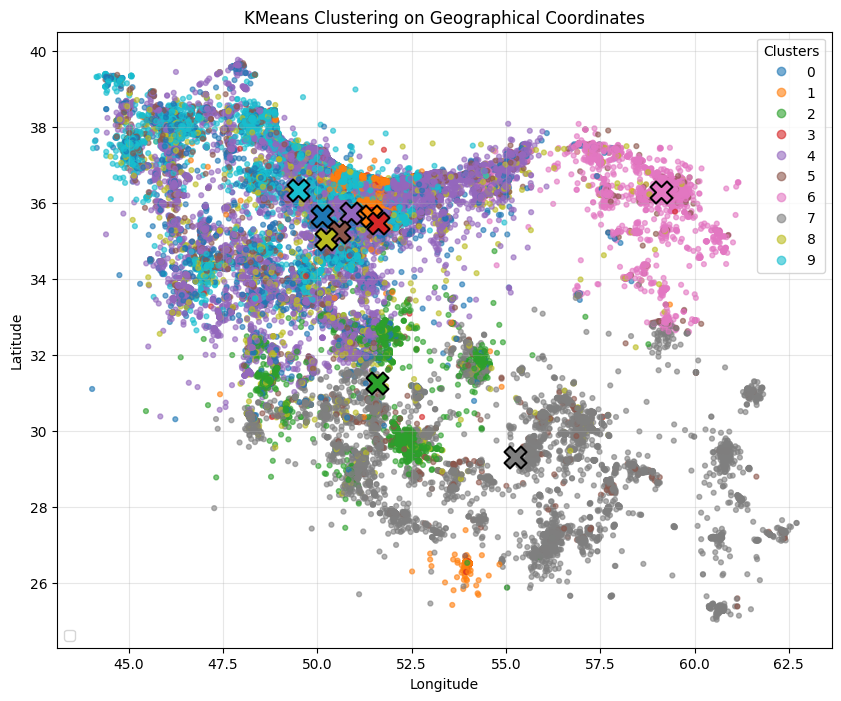

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
cmap = plt.get_cmap("tab10")
scatter = plt.scatter(
    df_model_sell["location_longitude"],
    df_model_sell["location_latitude"],
    c=df_model_sell["cluster"],
    cmap="tab10",
    s=12,
    alpha=0.6
)

for _, row in centroids_geo.iterrows():
    cluster_id = int(row["cluster"])
    plt.scatter(
        row["location_longitude"],
        row["location_latitude"],
        color=cmap(cluster_id),
        s=250,
        marker="X",
        edgecolor="black",
        linewidth=1.5,
        zorder=5
    )


# Legend خوشه‌ها
legend1 = plt.legend(
    *scatter.legend_elements(),
    title="Clusters",
    loc="upper right"
)
plt.gca().add_artist(legend1)

# Legend مراکز
plt.legend(loc="lower left")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clustering on Geographical Coordinates")

plt.grid(alpha=0.3)
plt.show()


In [29]:
pd.options.display.float_format = '{:.2f}'.format
cluster_analysis = (
    df_model_sell
    .groupby("cluster")
    .agg(
        count=("price_value", "count"),
        avg_price=("price_value", "mean"),
        median_price=("price_value", "median"),
        avg_size=("building_size", "mean"),
        avg_rooms=("rooms_num", "mean"),
        avg_year=("construction_year", "mean"),
        avg_lat=("location_latitude", "mean"),
        avg_lon=("location_longitude", "mean")
    )
    .round(2)
    .sort_values("avg_price")
)

print(cluster_analysis)


         count      avg_price   median_price  avg_size  avg_rooms  avg_year  \
cluster                                                                       
0        36780  2313893236.84  1500000000.00    110.21       0.78   1394.26   
4        82721  2578658538.72  2000000000.00    199.35       2.19   1398.93   
7        19987  2616505215.14  1700000000.00    250.58       2.09   1394.51   
6        26766  3773354701.36  2500000000.00    175.54       2.03   1396.05   
8        24004  4566705039.72  2973500000.00    148.37       2.08   1378.07   
9        59997  4729675338.71  3480000000.00    222.68       2.26   1397.83   
2        29990  5156719018.62  3700000000.00    198.34       2.23   1396.18   
1        70808  7671152311.03  6000000000.00    105.64       1.83   1391.96   
5         3948  7981512375.87  2700000000.00   4664.23       1.77   1391.67   
3         8202 47356304230.80 42000000000.00    347.96       2.94   1393.99   

         avg_lat  avg_lon  
cluster                

# just residental

In [30]:
df=data.copy()
df=df[df['cat2_slug']=='residential-sell']

In [31]:
df['rooms_num'] = df['rooms_count'].apply(parse_rooms).fillna(2)

In [32]:
amenity_cols = [
    'has_balcony',
    'has_elevator',
    'has_warehouse',
    'has_parking',
    'has_security_guard',
    'has_barbecue',
    'has_pool',
    'has_jacuzzi',
    'has_sauna'
]


In [33]:
features = [
    "price_value",
    "building_size",
    "rooms_num",
    "construction_year",
    "location_latitude",
    "location_longitude",
    "city_slug"
]+amenity_cols

df_model = df[features].copy()

In [34]:
num_cols = [
    "price_value",
    "building_size",
    "rooms_num",
    "construction_year"
]

geo_features=[
    "location_latitude",
    "location_longitude"
]

for col in num_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# df_model = df_model.dropna()

for col in geo_features:
    df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# df_model = df_model.dropna()

In [35]:
df_model = df_model.dropna(
    subset=["location_latitude","location_longitude","city_slug"]
).reset_index(drop=True)

In [36]:
df_model_sell = df_model[
    (df_model['price_value']>0) &
    (df_model['price_value']<200_000_000_000) &
    (df_model['building_size'].notna()) &
    (df_model['building_size']>5) &
    (df_model['building_size']<10000) &
    (df_model['location_latitude'].between(25, 40)) &
    (df_model['location_longitude'].between(44, 63))
].copy()
city_mean_price = (
    df_model_sell.groupby("city_slug")["price_value"]
            .mean()
)

df_model_sell["city_encoded"] = df_model_sell["city_slug"].map(city_mean_price)


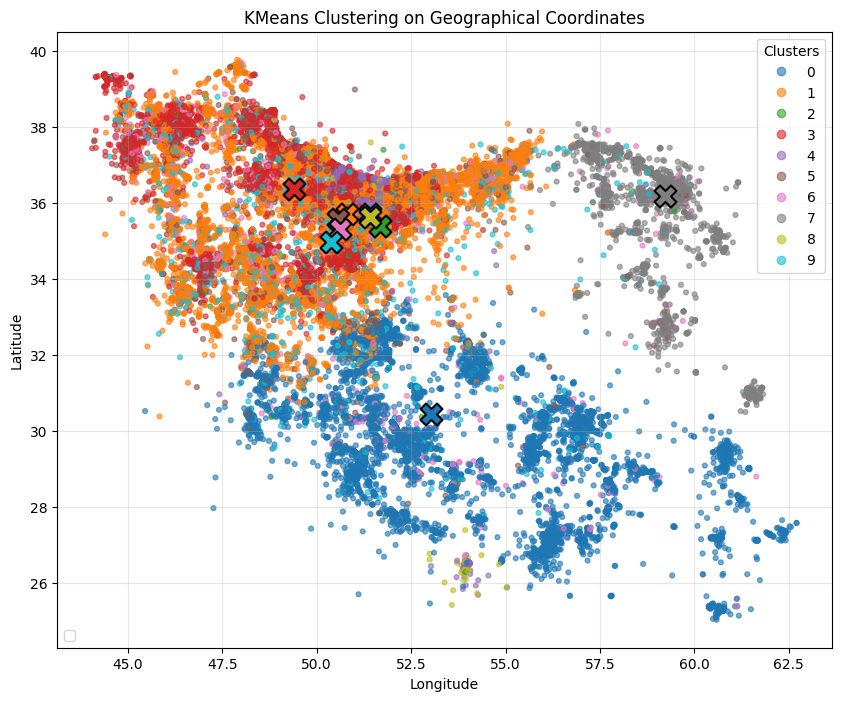

In [37]:


imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_num = imputer.fit_transform(df_model_sell[num_cols])
X_num = scaler.fit_transform(X_num)


X_geo = scaler.fit_transform(df_model_sell[geo_features])


city_encoded = imputer.fit_transform(
    df_model_sell[["city_encoded"]]
)
city_encoded = scaler.fit_transform(city_encoded)

weights = np.array([3, 1.5, 1, 1])  
X_weighted = X_num * weights
df_model_sell[amenity_cols] = (
    df_model_sell[amenity_cols]
    .replace({True: 1, False: 0, "yes": 1, "no": 0,'true':1,'false':0,'unselect':0})
)

amenity_imputer = SimpleImputer(strategy="most_frequent")

X_amenities = amenity_imputer.fit_transform(
    df_model_sell[amenity_cols]
)

X_amenities = scaler.fit_transform(X_amenities)

amenity_weight = 0.2   # قابل تنظیم
X_amenities = X_amenities * amenity_weight

city_weight = 2

X_final = np.hstack([
    X_num,
    X_geo,
    X_amenities,
    city_encoded * city_weight
])

kmeans = KMeans(
    n_clusters=10,
    random_state=42,
    n_init=10
)

df_model_sell["cluster"] = kmeans.fit_predict(X_final)

R = 6378137  # شعاع زمین (متر)

lat_rad = np.deg2rad(df_model_sell["location_latitude"])
lon_rad = np.deg2rad(df_model_sell["location_longitude"])

lat_mean = lat_rad.mean()

df_model_sell["utm_x"] = R * lon_rad * np.cos(lat_mean)
df_model_sell["utm_y"] = R * lat_rad

centroids_geo = (
    df_model_sell
    .groupby("cluster")[["location_latitude", "location_longitude"]]
    .mean()
    .reset_index()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
cmap = plt.get_cmap("tab10")
scatter = plt.scatter(
    df_model_sell["location_longitude"],
    df_model_sell["location_latitude"],
    c=df_model_sell["cluster"],
    cmap="tab10",
    s=12,
    alpha=0.6
)

# # رسم مراکز خوشه‌ها
for _, row in centroids_geo.iterrows():
    cluster_id = int(row["cluster"])
    plt.scatter(
        row["location_longitude"],
        row["location_latitude"],
        color=cmap(cluster_id),
        s=250,
        marker="X",
        edgecolor="black",
        linewidth=1.5,
        zorder=5
    )


# Legend خوشه‌ها
legend1 = plt.legend(
    *scatter.legend_elements(),
    title="Clusters",
    loc="upper right"
)
plt.gca().add_artist(legend1)

# Legend مراکز
plt.legend(loc="lower left")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clustering on Geographical Coordinates")

plt.grid(alpha=0.3)
plt.show()


In [38]:
pd.options.display.float_format = '{:.2f}'.format
df_model_sell["price_million"] = df_model_sell["price_value"] / 1_000_000
cluster_analysis = (
    df_model_sell
    .groupby("cluster")
    .agg(
        count=("price_value", "count"),
        avg_price=("price_value", "mean"),
        median_price=("price_value", "median"),
        avg_size=("building_size", "mean"),
        avg_rooms=("rooms_num", "mean"),
        avg_year=("construction_year", "mean"),
        avg_lat=("location_latitude", "mean"),
        avg_lon=("location_longitude", "mean")
    )
    .round(2)
    .sort_values("avg_price")
)

print(cluster_analysis)


amenity_summary = (
    df_model_sell
    .groupby('cluster')[amenity_cols]
    .mean()
    .round(2)
)

print(amenity_summary)

         count      avg_price   median_price  avg_size  avg_rooms  avg_year  \
cluster                                                                       
1        83230  2126743283.30  1650000000.00    169.98       1.81   1397.70   
3        55711  3331070243.85  2500000000.00    206.09       1.82   1396.65   
7        25320  3567239842.85  2400000000.00    175.76       2.06   1396.23   
0        44683  3623629061.45  2500000000.00    220.65       2.10   1395.80   
9        26232  3787744342.24  2550000000.00    122.42       1.97   1379.74   
8        30653  5269292576.84  4050000000.00     69.51       1.49   1385.69   
5        30232  7046975137.52  5600000000.00    202.93       3.30   1399.41   
6         3046  7062797408.75  2500000000.00   4513.68       1.97   1393.55   
4        38084  9880768580.95  8432500000.00    136.52       2.20   1398.17   
2         6515 49761759014.03 45000000000.00    344.56       3.03   1393.96   

         avg_lat  avg_lon  
cluster                

# Finding best K

In [39]:
from sklearn.cluster import KMeans

wcss = []
K_range = range(1, 21)

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_final)
    wcss.append(kmeans.inertia_)  # WCSS


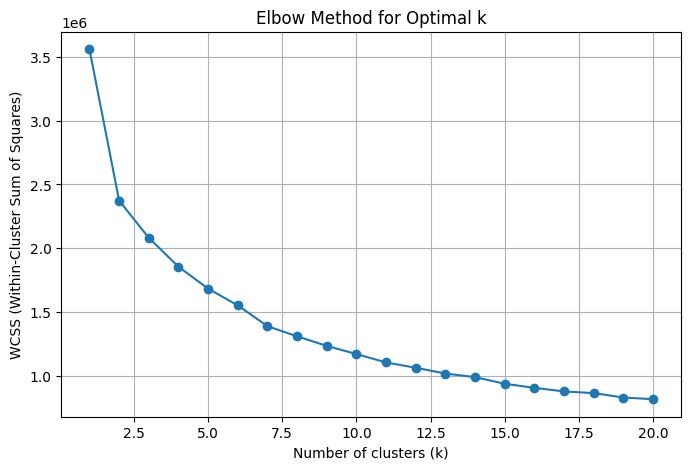

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


In [41]:
wcss_diff = np.diff(wcss)
wcss_diff2 = np.diff(wcss_diff)

for i in range(len(wcss_diff2)):
    print(f"k={i+2} → curvature={wcss_diff2[i]:.2f}")


k=2 → curvature=895700.98
k=3 → curvature=64739.69
k=4 → curvature=55127.76
k=5 → curvature=40492.93
k=6 → curvature=-31881.41
k=7 → curvature=83515.94
k=8 → curvature=4705.89
k=9 → curvature=10685.36
k=10 → curvature=-1361.96
k=11 → curvature=23766.26
k=12 → curvature=-3372.12
k=13 → curvature=17103.50
k=14 → curvature=-24310.43
k=15 → curvature=20883.82
k=16 → curvature=3256.83
k=17 → curvature=14884.21
k=18 → curvature=-20955.73
k=19 → curvature=20920.05


# PartIII-DBSCAN


In [54]:
df=data.copy()

In [55]:
df.head()

,Unnamed: 0,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,user_type,description,title,rent_mode,...,regular_person_capacity,extra_person_capacity,cost_per_extra_person,rent_price_on_regular_days,rent_price_on_special_days,rent_price_at_weekends,location_latitude,location_longitude,location_radius,year_month
1,1,residential-sell,apartment-sell,tehran,gholhak,2024-05-01,مشاور املاک,دسترسی عالی به مترو و شریعتی \nمشاعات تمیز \nب...,60 متر قلهک فول امکانات,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.00,2024-05
4,4,residential-sell,apartment-sell,mashhad,emamreza,2024-05-01,مشاور املاک,هلدینگ ساختمانی اکبری\n\nهمراه شما هستیم برای ...,115 متری/شمالی رو به آفتاب/اکبری,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05
7,7,residential-sell,apartment-sell,tehran,dardasht,2024-09-01,مشاور املاک,♡♡♡♡♡♡بنام خدا♡♡♡♡♡♡\n♡♡♡عرض ادب واحترام♡♡♡\n♡...,اپارتمان 100متری طبقه3و4 فول دردشت شمالی,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.73,51.51,500.00,2024-09
8,8,residential-sell,apartment-sell,mahdasht-city,NaN,2024-06-01,مشاور املاک,با سلام\n\nاملاک بزرگ اتحاد با 2شعبه فعال با ف...,78متری دوبحرنورگیر بازسازی شده شیک سندتک برگ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.71,50.79,500.00,2024-06
9,9,residential-sell,apartment-sell,mashhad,faramarzabbasi,2024-10-01,NaN,اول رسالت فرد نزدیک به حاشیه فرامرز .. ساکنین...,متراژ 80 متر فرامرز نزدیک حاشیه,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-10


In [ ]:
from sklearn.cluster import DBSCAN
df=pd.read_csv("Divar.csv")

# df[["location_latitude","location_longitude","transformable_price"]].isna().mean()
df = df.dropna(
    subset=["location_latitude","location_longitude","transformable_price"]
).reset_index(drop=True)

# پروجکشن WGS84 -> UTM Zone 39N (مناسب ایران)
proj_utm = pyproj.Proj(proj="utm", zone=39, ellps="WGS84")

utm_x, utm_y = proj_utm(
    df["location_longitude"].values,
    df["location_latitude"].values
)

df["utm_x"] = utm_x
df["utm_y"] = utm_y

In [63]:
df_sample = df.sample(
    n=10000,        # یا 30000 بسته به RAM
    random_state=42
)


In [64]:
X_db = df_sample[["utm_x", "utm_y", "transformable_price"]]

X_db_scaled = StandardScaler().fit_transform(X_db)

dbscan = DBSCAN(
    eps=0.6,
    min_samples=50,
    algorithm="ball_tree"   # مهم
)

df_sample["dbscan_cluster"] = dbscan.fit_predict(X_db_scaled)


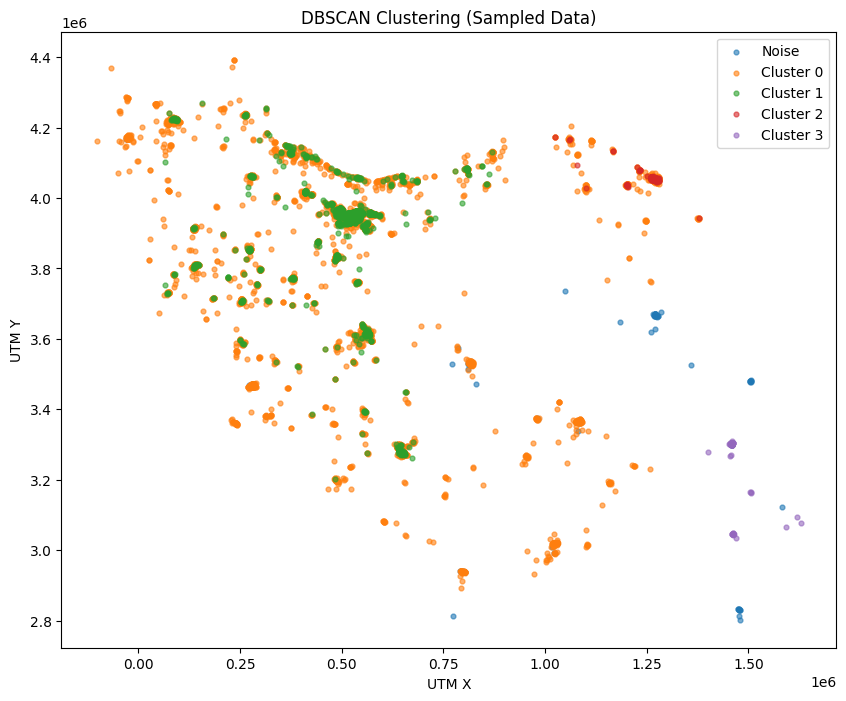

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

for c in sorted(df_sample["dbscan_cluster"].unique()):
    subset = df_sample[df_sample["dbscan_cluster"] == c]
    label = "Noise" if c == -1 else f"Cluster {c}"
    
    plt.scatter(
        subset["utm_x"],
        subset["utm_y"],
        s=12,
        alpha=0.6,
        label=label
    )

plt.xlabel("UTM X")
plt.ylabel("UTM Y")
plt.title("DBSCAN Clustering (Sampled Data)")
plt.legend()
plt.show()
